## _*Quantum SVM (quantum kernel method)*_

### Introduction

Please refer to [this file](https://github.com/Qiskit/qiskit-tutorials/blob/master/qiskit/aqua/artificial_intelligence/qsvm_kernel_classification.ipynb) for introduction.

In this file, we show two ways for using the quantum kernel method: (1) the non-programming way and (2) the programming way. 


### Part I: non-programming way.
In the non-programming way, we config a json-like configuration, which defines how the svm instance is internally constructed. After the execution, it returns the json-like output, which carries the important information (e.g., the details of the svm instance) and the processed results. 

In [1]:
from datasets import *
from qiskit import Aer
from qiskit.qobj import RunConfig
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import run_algorithm, QuantumInstance
from qiskit.aqua.input import SVMInput
from qiskit.aqua.components.feature_maps import SecondOrderExpansion
from qiskit.aqua.algorithms import QSVMKernel

First we prepare the dataset, which is used for training, testing and the finally prediction.

*Note: You can easily switch to a different dataset, such as the Breast Cancer dataset, by replacing 'ad_hoc_data' to 'Breast_cancer' below.*

In [2]:
feature_dim = 2 # dimension of each data point
training_dataset_size = 20
testing_dataset_size = 10
random_seed = 10598
shots = 1024

sample_Total, training_input, test_input, class_labels = ad_hoc_data(training_size=training_dataset_size, 
                                                                     test_size=testing_dataset_size, 
                                                                     n=feature_dim, gap=0.3, PLOT_DATA=False)

datapoints, class_to_label = split_dataset_to_data_and_labels(test_input)
print(class_to_label)

{'A': 0, 'B': 1}


Now we create the svm in the non-programming way.
In the following json, we config:
- the algorithm name 
- the feature map 

In [3]:
params = {
    'problem': {'name': 'svm_classification', 'random_seed': random_seed},
    'algorithm': {
        'name': 'QSVM.Kernel'
    },
    'backend': {'shots': shots},
    'feature_map': {'name': 'SecondOrderExpansion', 'depth': 2, 'entanglement': 'linear'}
}
backend = Aer.get_backend('qasm_simulator')
algo_input = SVMInput(training_input, test_input, datapoints[0])

With everything setup, we can now run the algorithm.

The run method includes training, testing and predict on unlabeled data.

For the testing, the result includes the success ratio.

For the prediction, the result includes the predicted class names for each data.

After that the trained model is also stored in the svm instance, you can use it for future prediction.

In [4]:
result = run_algorithm(params, algo_input, backend=backend)

kernel matrix during the training:


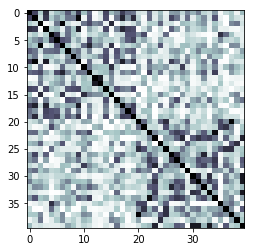

testing success ratio:  1.0
predicted classes: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']


In [5]:
print("kernel matrix during the training:")
kernel_matrix = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_matrix),interpolation='nearest',origin='upper',cmap='bone_r')
plt.show()

print("testing success ratio: ", result['testing_accuracy'])
print("predicted classes:", result['predicted_classes'])

### part II: Programming way.
We construct the svm instance directly from the classes. The programming way offers the users better accessibility, e.g., the users can access the internal state of svm instance or invoke the methods of the instance. We will demonstrate this advantage soon.

Now we create the svm in the programming way.
- We build the svm instance by instantiating the class QSVMKernel. 
- We build the feature map instance (required by the svm instance) by instantiating the class SecondOrderExpansion.

In [6]:
backend = Aer.get_backend('qasm_simulator')
feature_map = SecondOrderExpansion(num_qubits=feature_dim, depth=2, entangler_map=[[0, 1]])
svm = QSVMKernel(feature_map, training_input, test_input, None)# the data for prediction can be feeded later.
svm.random_seed = random_seed
run_config = RunConfig(shots=shots, max_credits=10, memory=False, seed=random_seed)
quantum_instance = QuantumInstance(backend, run_config, seed_mapper=random_seed)
result = svm.run(quantum_instance)

Let us check the result.

kernel matrix during the training:


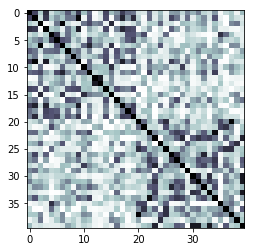

testing success ratio:  1.0


In [7]:
print("kernel matrix during the training:")
kernel_matrix = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_matrix),interpolation='nearest',origin='upper',cmap='bone_r')
plt.show()

print("testing success ratio: ", result['testing_accuracy'])

Different from the non-programming way, the programming way allows the users to invoke APIs upon the svm instance directly. In the following, we invoke the API "predict" upon the trained svm instance to predict the labels for the newly provided data input.

Use the trained model to evaluate data directly, and we store a `label_to_class` and `class_to_label` for helping converting between label and class name

In [8]:
predicted_labels = svm.predict(datapoints[0])

predicted_classes = map_label_to_class_name(predicted_labels, svm.label_to_class)
print("ground truth: {}".format(datapoints[1]))
print("preduction:   {}".format(predicted_labels))

ground truth: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
preduction:   [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
